# Data Driven Models in Engineering 

**Konstantinos Papadakis**

Masters program in Data Science and Machine Learning, National Technical University of Athens

Student Number: 03400149

email: k.i.papadakis@gmail.com, konstantinospapadakis@mail.ntua.gr


## Introduction

In this document we will attempt to detect ***extreme turning movements*** of a car while having the following data available:

* Acceleration values in three axes

* Rotation rate values in three axes (yaw, pitch, roll)

* Speed measured by GPS 

The Acceleration and Rotation values are measured by the driver's smartphone's Accelerometer and Gyroscope respectively.
These values have been undergone certain transformations so that their axes align with the car's axes as shown in the the image below.

<img src='phone-and-car-axes.png' width="600">

The values which we consider as important in describing a turning movement are the Roll, the Yaw and the acceleration in the X axis. 
The Pitch and the acceleration in the Y axis mainly describe forward acceleration and deceleration, so we will not use them to detect extreme turning movements.

We will perform outlier detection using the selected fields to detect those extreme turning movements. We will assume that roughly 1% of our data points are outliers and use this assumption in the algorithms.


## Time Independent Approach

We first plot a small sample (n=5000) of our data and notice that they are rougly normally distributed. This motivates us to fit a single Normal distribution on our data and consider as outliers the datapoints whose density is lower than a threshold, that threshold being such that 1% of our data are outliers.

Also, since our data seem to form a single cluster, outlier detection using K-Means with K > 2 is most probably not going to uncover any interesting structures.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from adtk.detector import AutoregressionAD
from adtk.visualization import plot as adtkplot


RANDOM_STATE = 7
CONTAMINATION = 0.01
DATA_PATH = 'all_LAT_uns.csv'
TURN_COLS = [
    'NewRotRateY',
    'NewRotRateZ',
    'NewAccelX',
]


In [2]:
# Load and plot the data
df_all = pd.read_csv(DATA_PATH)
df = df_all[TURN_COLS]

rng = np.random.default_rng(RANDOM_STATE)
sample_indices = rng.choice(len(df), 5_000, replace=False)
is_sample = np.full(len(df), False, bool)
is_sample[sample_indices] = True

def plot_outliers(data, preds, mask=None, title=None):
    if mask is not None:
        preds = preds[mask]
        data = data[mask]
    colors = np.where(preds == 1, 'regular', 'outlier')
    fig = px.scatter_3d(
        data, *TURN_COLS,
        color=colors,
        color_discrete_sequence=['blue', 'red'],
        title=f'{title} ({len(data)} samples)'
    )
    fig.show()
    
fig = px.scatter_3d(df[is_sample], *TURN_COLS)
fig.show()


### Normal Distribution

We fit a normal distribution to our data and plot the results in a interactive 3D plot.

In [3]:
# ELLIPTIC ENVELOPE

ee = EllipticEnvelope(contamination=CONTAMINATION, random_state=RANDOM_STATE)
ee_preds =ee.fit_predict(df)

plot_outliers(
    df, ee_preds, mask=is_sample,
    title=f'Gaussian Outlier Detection (contamination={ee.contamination})',
)


### Local Outlier Factor

We then try a Local Outlier Factor model which is a density based outlier detection algorithm instead of a distance based one. We expect the results to be very different compared to the Normal ellipsoid fit, and we readily see that they are indeed! All outliers lie inside the "main" cluster and we need to zoom a lot to find them! This is probably not what we are looking for though...

In [4]:
# LOCAL OUTLIER FACTOR
lof = LocalOutlierFactor(n_neighbors=20, contamination=CONTAMINATION)
lof_preds = lof.fit_predict(df)

print('Number of outliers: {}'.format(np.sum(lof_preds[is_sample] == -1)))

plot_outliers(
    df, lof_preds, mask=is_sample,
    title=f'LOF (contamination={lof.contamination})'
)


Number of outliers: 43


### Isolation Forest

 The final model we will try in our time independent approach is a tree based one, namely an Isolation Forest.
 The Isolation Forest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The average path length required to isolate a data point is considered a measure of irregularity - the shorter the path, the more anomalous the point is considered.

 We notice that the Isolation forest produces similar results to the Normal Envelope.


In [5]:
# ISOLATION FOREST
isfo = IsolationForest(n_estimators=100, contamination=CONTAMINATION)
isfo_preds = isfo.fit_predict(df)

plot_outliers(
    df, isfo_preds, mask=is_sample,
    title=f'Isolation Forest (contamination={isfo.contamination})'
)


c:\Users\konpa\projects\datadriven-exercises\assignment3\env\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



## Time Series Approach

We now view our data as a sequence in time. To simplify things and produce better visual results, will use a single variable approach, with that single variable being the euclidean norm of the vector formed by our variables of interest.

In [6]:
norms = (df ** 2).sum(axis=1) ** 0.5
time_index = pd.date_range(start='2021', periods=len(norms), freq='1S')
norms = norms.set_axis(time_index)
norms.name = 'sqrt(' + ' + '.join(f'{col} ^ 2' for col in TURN_COLS) + ')'

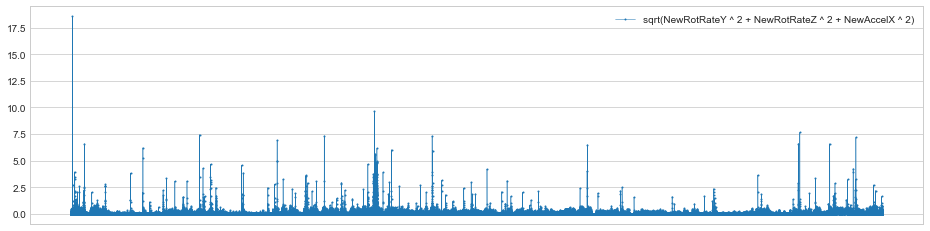

In [7]:
adtkplot(norms)
plt.xticks([], [])
plt.show()

### Autoregressive Model

A simple autoregressive model of order 10 is attempted to be fitted on our data. We then attempt to predict the same data with that model. If our prediction for a data point is "off", we consider that data point to be an outlier. We view our data point as normal if the difference between the predicted and the true value lies in  `[Q1 - c*IQR, Q3 + c*IQR]` where `IQR=Q3−Q1` and `Q1`, `Q3` are the 25% and 75% quantiles respectively. We manually picked `c=12.5` so that the number of outliers is roughly 1%, so that we (hopefully) get results similar to the time-independent approach. 

An important thing to be noted here is that typically a time series approach requires our model to be trained on normal data only. But since our model is a very low capacity one, it can't really learn many irregular structures, so it roughly ends up with the same weights as if it was trained on regular only data. On the other hand, if for example we used an LSTM with an Autoencoder and many parameters, then that Autoencoder would easily learn to reconstruct irregular data with just a few samples, thus rendering it useless for our case.  

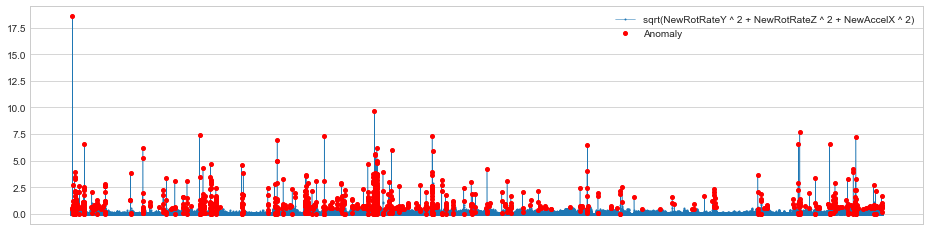

In [8]:
# Auto-Regression
# c is used to compute the interval where the regular values lie:
# [Q1−c*IQR, Q3+c*IQR] where IQR=Q3−Q1 and Q1, Q3 the the 25% and 75% quantiles]
c = 12.5  # results to about 0.01 contamination
arad = AutoregressionAD(n_steps=10, step_size=1, c=c, side='both')
arad_preds = arad.fit_detect(norms)

adtkplot(norms, anomaly=arad_preds, anomaly_color="red", anomaly_tag="marker")
plt.xticks([], [])
plt.show()

## Results Comparison

Finally we compare the results between our algorithms. Specifically we count the overlap between the outliers that they detected. The results are shown on the table below.
We see that besides the Local Outlier Factor algorithm, the rest of the algorithms found many of the same data points to be outliers.
This happened because the Local Outlier Factor isn't influenced much by the notion distance, but is mainly considered with the notion of local density, while the other algorithms are heavily influenced by the distance between points, be it directly like in the case of the Normal Envelope, or indirectly like in the case of the IsolationForest. 

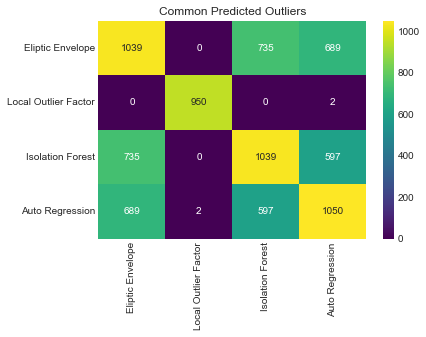

In [9]:
# Find Overlap
preds = pd.DataFrame.from_dict({
    'Eliptic Envelope': ee_preds,
    'Local Outlier Factor': lof_preds,
    'Isolation Forest': isfo_preds,
    'Auto Regression': np.where(arad_preds.fillna(False), -1, 1),
}, dtype=int)

res = np.empty((preds.shape[1], preds.shape[1]), int)
for i, col1 in enumerate(preds.columns):
    for j, col2 in enumerate(preds.columns):
        n_same_outliers = (preds[col1] + preds[col2] == -2).sum()
        res[i, j] = n_same_outliers

res = pd.DataFrame(res, index=preds.columns, columns=preds.columns, dtype=int)

ax = sns.heatmap(res, annot=True, fmt='d', cmap='viridis')
ax.set_title('Common Predicted Outliers')
plt.show()

In [10]:
# EXPORT RESULTS
# preds.to_csv('predictions.csv', index=False)